In [1]:
import pandas as pd
from glob import glob
from PIL import Image, ImageDraw
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random 
from ultralytics import YOLO
from tqdm import tqdm
%matplotlib inline


In [2]:
def get_images_labels(path, folder_name):
    labels = glob(f'{path}/train_labels/train_labels/{folder_name}*')
    labels = sorted(labels)
    imgs = glob(f'{path}/data/train/{folder_name.split("_")[0]}/{folder_name}*')
    imgs = sorted(imgs)
    return labels, imgs

def generate_random_color():
    """Generate a bright, random color."""
    return tuple(random.randint(100, 255) for _ in range(3))  # RGB values


def stack_images_vertically(image_paths):
    '''Stack images vertically into a single PIL image cropping to the minimum width'''
    images = [Image.open(path) for path in image_paths]
    widths, heights = zip(*(i.size for i in images))
    min_width = min(widths)
    total_height = sum(heights)
    stacked_image = Image.new('RGB', (min_width, total_height))
    y_offset = 0
    for im in images:
        if im.width > min_width:
            im = im.crop((0,0, min_width, im.height))
        stacked_image.paste(im, (0, y_offset))
        y_offset += im.height
    return stacked_image

In [3]:
def prepare_stacked_data(image_paths, label_paths):
    '''
    Prepare a stacked image and combined mask string from matching image-label pairs

    Args:
    image_paths (list): List of paths to image files
    label_paths (list): List of paths to label files

    Return:
        tuple: (stacked_image, combined_masks_str)
            - stacked images: PIL image object of the stacked images.
            -combined_mask_str: string combining all mask annotations.
    '''

    # create a dictionary mapping the label base names to their full paths 
    label_map = {os.path.splitext(os.path.basename(lf))[0]: lf for lf in label_paths}
    matching_images = []
    matching_labels = []

    # match images with corresponding labels
    for image_path in image_paths:
        image_name = os.path.splitext(os.path.basename(image_path))[0]
        if image_name in label_map:
            matching_images.append(image_path)
            matching_labels.append(label_map[image_name])

    #print feedback for debugging
    #print(f'found {len(image_paths)} images and {len(label_paths)} labels')
    #print(f'Matched {len(matching_images)} image-label pairs.')
    
    images = [Image.open(path) for path in matching_images]
    if len(images) == 0:
        images = [Image.open(path) for path in image_paths]
    widths, heights = zip(*(i.size for i in images))
    min_width = min(widths)
    total_height = sum(heights)

    #stack images vertically
    stacked_image = Image.new('RGB', (min_width, total_height))
    y_offset = 0
    for im in images:
        im_resized = im.resize((min_width, im.height))
        stacked_image.paste(im_resized, (0, y_offset))
        y_offset += im.height
    # Handle case where no matching pairs were found
    combined_mask_lines = []
    cummulative_height = 0
    for label_path, im_height, im_width in zip(matching_labels, heights, widths):
        with open(label_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) < 3:
                    continue
                class_id = parts[0]
                coords = list(map(float, parts[1:]))
                new_coords = []
                for x_norm, y_norm in zip(coords[0::2], coords[1::2]):
                    x_pixel = int(x_norm * im_width)
                    y_pixel = int(y_norm * im_height)
                    x_pixel_cropped = min(x_pixel, min_width - 1)
                    y_pixel_offset = y_pixel + cummulative_height
                    new_x_norm = x_pixel_cropped / min_width
                    new_y_norm = y_pixel_offset / total_height
                    new_coords.extend([new_x_norm, new_y_norm])
                new_line = class_id + " " + " ".join(f'{val:.6f}' for val in new_coords)
                combined_mask_lines.append(new_line)

        cummulative_height += im_height
    combined_masks_str = '\n'.join(combined_mask_lines)
    
    return stacked_image, combined_masks_str        

In [4]:
def get_polygons_from_mask_str(mask_str, img_width, img_height):
    polygons = []
    # split into lines (each line is a polygon)
    lines = mask_str.strip().split('\n')
    for line in lines:
        #split line into parts (class id and coordinates)
        parts = lines.strip().split()
        if len(parts) < 3:
            continue
        #convert the coordinates into floats skipping the class id
        coords = list(map(float, parts[1:]))
        if len(coords) % 2 != 0: #must have an even number for (x, y) pairs
            continue
        # Group into (x,y) pairs and convert to pixel coordinates
        points = [(int(x * img_width), int(y * img_height))
                  for x, y in zip(coords[0::2], coords[1::2])]
        
        #convert to numpy arrayand append to list
        polygons.append(np.array(points, dtype=np.int32))
    return polygons

def visualize(stacked_image, polygons):
    #Visualize with polygons
    image = np.array(stacked_image)
    for polygon in polygons:
        if polygon.shape[0]:
            color=generate_random_color()
            cv2.polylines(image, [polygon.astype(int)], isClosed=True, color = color, thickness=1)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [5]:
##Main execution

#set paths
PATH = 'C:/Users/Reinhard/Documents/computer_vision_projects/root_volume_estimation_challenge'
train = pd.read_csv('Train.csv')
output_dir = './seg/images'
labels_dir = './seg/labels'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

#Organizing the data for training

for f in tqdm(train.FolderName.unique()):
    for side in ['L', 'R']:
        labels, imgs = get_images_labels(PATH, f'{f}_{side}_')
        if imgs and labels:
            stacked_image, mask_str = prepare_stacked_data(imgs, labels)
            output_path = f'{output_dir}/{f}_{side}.png'
            stacked_image.save(output_path)
            with open(output_path.replace('images', 'labels').replace('.png', '.txt'), 'w') as fx:
                fx.write(mask_str)


100%|██████████| 98/98 [00:10<00:00,  9.24it/s]


In [12]:
print(len('C:/Users/Reinhard/Documents/computer_vision_projects/root_volume_estimation_challenge/data/train'))

96


In [15]:
print((labels_dir))

./seg/labels


In [ ]:
image_path = os.path.join(output_dir, 'A2miww5mfx_L.png')
label_path = os.path.join(labels_dir, 'A2miww5mfx_L.txt')

image = Image.open(image_path)
w, h = image.size

if os.path.exists(label_path):
    with open(label_path) as f:
        mask_str = f.read()
    polygons = get_polygons_from_mask_str(mask_str, w, h)
    visualize(image, polygons)
else:
    print(f"Label file not found: {label_path}")

AttributeError: 'list' object has no attribute 'strip'

In [ ]:
# Create YAML configuration for YOLO
yaml_content = """
path: seg
train: images
val: images
names: 
    0:root
"""

with open (f'./seg/config.yaml', 'w') as f:
    f.write(yaml_content.strip())

#Train the model on combned images
model = YOLO('yolo11Vl-seg.pt')
model.train(data=f'*./seg/config.yaml', epochs=100, imgsz=640)


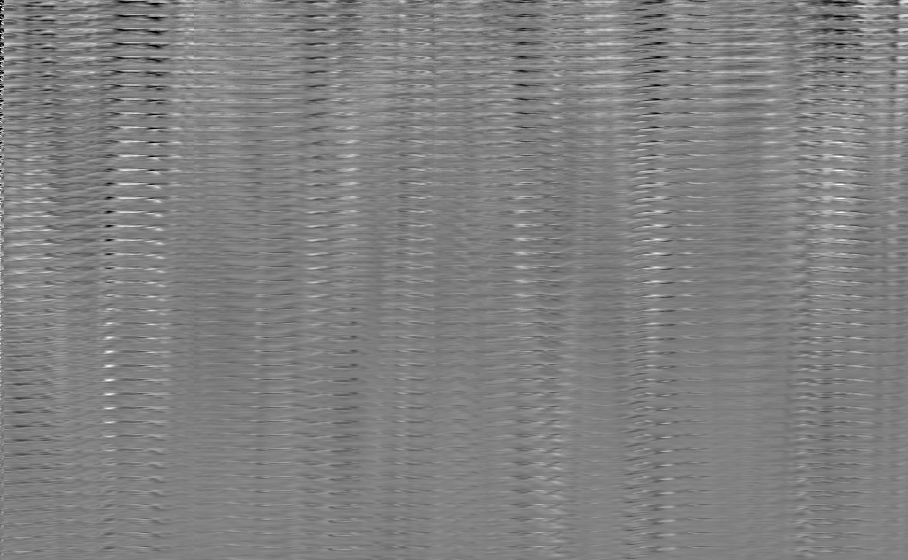

In [21]:
#Inference and visualization example
#select example images

folders = train.FolderName.unique()
example_folder = folders[0]
example_side = 'L'
labels, imgs = get_images_labels(PATH, F'{example_folder}_{example_side}_')
stacked_image, _ = prepare_stacked_data(imgs[20:60], labels[20:60])
stacked_image

In [ ]:
model = YOLO('./runs/segment/train7/weights/best.pt')

#perfrom inference
results = model(stacked_image)
polygons = results[0].masks.xy
visualize(stacked_image, polygons)